## Load Stats about Pairs File

In [1]:
import pandas as pd

# Cell 2: Load and analyze pairs
import pandas as pd
top3_path = "/home/bjangley/VPR/mast3r-v2/mined_step50/spagna_matches_inliers_fm_top3_anchors_per_query_per_anchorseq.csv"
df = pd.read_csv(top3_path)

# Group by anchor_seq and query_seq and count the number of pairs
pair_counts = df.groupby(['anchor_seq', 'query_seq']).size().reset_index(name='num_pairs')

# Print the counts
print(pair_counts)
print("Total number of pairs:", pair_counts['num_pairs'].sum())



# Group by anchor_seq and query_seq and compute median and mean for num_inliers
inliers_stats = df.groupby(['anchor_seq', 'query_seq'])['num_inliers'].agg(['mean', 'median']).reset_index()

# Print the results
print("Per Anchor-Query Sequence Median and Mean num_inliers:")
print(inliers_stats)

    anchor_seq  query_seq  num_pairs
0            0          3        120
1            0         10        120
2            4          3        120
3            4          5        120
4            4         10        120
5            4         11        120
6            4         12        120
7            4         19        120
8            7         14        120
9           13         15        120
10          20          2        120
11          20         21         27
Total number of pairs: 1347
Per Anchor-Query Sequence Median and Mean num_inliers:
    anchor_seq  query_seq         mean  median
0            0          3  1142.383333  1392.5
1            0         10  1162.525000  1478.5
2            4          3   737.058333   724.5
3            4          5   568.775000   340.0
4            4         10   950.066667   875.5
5            4         11  1147.833333  1142.0
6            4         12   152.891667    99.5
7            4         19   580.333333   591.5
8            

In [2]:
def load_statistics(pointcloud_type, base_path="results_step50"):
    """
    Load statistics for a specified point cloud type.
    Auto-detects column structure from the data.
    """
    # Construct the file path based on the point cloud type
    statistics_file = f"{base_path}/spagna_{pointcloud_type}_statistics.txt"
    
    try:
        # First, read without column names to detect structure
        df_temp = pd.read_csv(statistics_file, delim_whitespace=True, header=None)
        num_columns = len(df_temp.columns)
        
        # Define column names based on detected structure
        if num_columns == 14:
            # Basic methods (mast3r, lidar)
            columns = [
                "query_seq", "anchor_seq", "query_idx", "anchor_idx",
                "num_matches", "num_inliers", "median_depth",
                "x_error", "y_error", "z_error", "pos_error", "rot_error", 
                "distance_anchor_query", "status"
            ]
        elif num_columns == 16:
            # Scaled methods with single scale (mast3r_scaled_v3)
            columns = [
                "query_seq", "anchor_seq", "query_idx", "anchor_idx",
                "num_matches", "num_inliers", "median_depth",
                "x_error", "y_error", "z_error", "pos_error", "rot_error", 
                "distance_anchor_query", "pointmap_error", "scale", "status"
            ]
        elif num_columns == 18:
            # Scaled methods with three scales (mast3r_scaled_v4, mast3r_scaled_icp)
            columns = [
                "query_seq", "anchor_seq", "query_idx", "anchor_idx",
                "num_matches", "num_inliers", "median_depth",
                "x_error", "y_error", "z_error", "pos_error", "rot_error", 
                "distance_anchor_query", "pointmap_error", 
                "scale_x", "scale_y", "scale_z", "status"
            ]
        else:
            raise ValueError(f"Unexpected number of columns ({num_columns}) for {pointcloud_type}")
        
        # Reload with proper column names
        df = pd.read_csv(statistics_file, delim_whitespace=True, names=columns)
        print(f"Loaded statistics for {pointcloud_type}: {num_columns} columns detected")
        return df
        
    except FileNotFoundError:
        print(f"Error: File not found for point cloud type: {pointcloud_type}")
        return None

In [3]:
import pandas as pd
import numpy as np

# Load all datasets
results = ['mast3r', 'lidar', 'mast3r_scaled_v3', 'mast3r_scaled_v4', 'mast3r_scaled_icp']
loaded_data = {}

for pointcloud_type in results:
    df = load_statistics(pointcloud_type)
    if df is not None:
        # Convert numeric columns
        numeric_columns = ["num_matches", "num_inliers", "median_depth", "x_error", "y_error", "z_error", "pos_error", "rot_error"]
        if "pointmap_error" in df.columns:
            numeric_columns.append("pointmap_error")
        if "distance_anchor_query" in df.columns:
            numeric_columns.append("distance_anchor_query")
        
        # Add scale columns
        scale_cols = [col for col in df.columns if col.startswith("scale")]
        numeric_columns.extend(scale_cols)
        
        for col in numeric_columns:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors="coerce")
        
        loaded_data[pointcloud_type] = df

# Table 1: Success rate and num_inliers (median)
table1_data = []
for pointcloud_type, df in loaded_data.items():
    ok_pairs = df[df['status'] == 'OK']
    table1_data.append({
        'method': pointcloud_type,
        'n_success': len(ok_pairs),
        'n_total': len(df),
        'success_rate': len(ok_pairs) / len(df) if len(df) > 0 else 0,
        'num_inliers_median': ok_pairs['num_inliers'].median() if len(ok_pairs) > 0 else np.nan
    })

table1 = pd.DataFrame(table1_data)
print("Table 1: Success Rates and Inliers")
print(table1)
print()

# Table 2: Position and rotation errors (median)
table2_data = []
for pointcloud_type, df in loaded_data.items():
    ok_pairs = df[df['status'] == 'OK']
    table2_data.append({
        'method': pointcloud_type,
        'pos_error_median': ok_pairs['pos_error'].median() if len(ok_pairs) > 0 else np.nan,
        'x_error_median': ok_pairs['x_error'].median() if len(ok_pairs) > 0 else np.nan,
        'y_error_median': ok_pairs['y_error'].median() if len(ok_pairs) > 0 else np.nan,
        'z_error_median': ok_pairs['z_error'].median() if len(ok_pairs) > 0 else np.nan,
        'rot_error_median': ok_pairs['rot_error'].median() if len(ok_pairs) > 0 else np.nan
    })

table2 = pd.DataFrame(table2_data)
print("Table 2: Position and Rotation Errors (Median)")
print(table2)
print()

# Table 3: Distance and scales (mean and median)
table3_data = []
for pointcloud_type, df in loaded_data.items():
    ok_pairs = df[df['status'] == 'OK']
    
    row = {
        'method': pointcloud_type,
        'distance_mean': ok_pairs['distance_anchor_query'].mean() if 'distance_anchor_query' in ok_pairs.columns and len(ok_pairs) > 0 else np.nan,
        'distance_median': ok_pairs['distance_anchor_query'].median() if 'distance_anchor_query' in ok_pairs.columns and len(ok_pairs) > 0 else np.nan,
    }
    
    # Add scale statistics
    if 'scale' in ok_pairs.columns:
        # row['scale_mean'] = ok_pairs['scale'].mean() if len(ok_pairs) > 0 else np.nan
        row['scale_median'] = ok_pairs['scale'].median() if len(ok_pairs) > 0 else np.nan
    
    if 'scale_x' in ok_pairs.columns:
        # row['scale_x_mean'] = ok_pairs['scale_x'].mean() if len(ok_pairs) > 0 else np.nan
        row['scale_x_median'] = ok_pairs['scale_x'].median() if len(ok_pairs) > 0 else np.nan
    
    if 'scale_y' in ok_pairs.columns:
        # row['scale_y_mean'] = ok_pairs['scale_y'].mean() if len(ok_pairs) > 0 else np.nan
        row['scale_y_median'] = ok_pairs['scale_y'].median() if len(ok_pairs) > 0 else np.nan
    
    if 'scale_z' in ok_pairs.columns:
        # row['scale_z_mean'] = ok_pairs['scale_z'].mean() if len(ok_pairs) > 0 else np.nan
        row['scale_z_median'] = ok_pairs['scale_z'].median() if len(ok_pairs) > 0 else np.nan
    
    table3_data.append(row)

table3 = pd.DataFrame(table3_data)
print("Table 3: Distance and Scale Statistics")
print(table3)

Loaded statistics for mast3r: 14 columns detected
Loaded statistics for lidar: 14 columns detected
Loaded statistics for mast3r_scaled_v3: 16 columns detected
Loaded statistics for mast3r_scaled_v4: 18 columns detected
Loaded statistics for mast3r_scaled_icp: 16 columns detected
Table 1: Success Rates and Inliers
              method  n_success  n_total  success_rate  num_inliers_median
0             mast3r       1000     1347      0.742390               740.5
1              lidar        996     1347      0.739421               743.0
2   mast3r_scaled_v3       1000     1347      0.742390               740.5
3   mast3r_scaled_v4        998     1347      0.740906               742.0
4  mast3r_scaled_icp       1000     1347      0.742390               740.5

Table 2: Position and Rotation Errors (Median)
              method  pos_error_median  x_error_median  y_error_median  \
0             mast3r          5.578290        2.005828        0.220616   
1              lidar          0.353160 

/tmp/ipykernel_1499165/2164797308.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_temp = pd.read_csv(statistics_file, delim_whitespace=True, header=None)
/tmp/ipykernel_1499165/2164797308.py:44: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(statistics_file, delim_whitespace=True, names=columns)
/tmp/ipykernel_1499165/2164797308.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_temp = pd.read_csv(statistics_file, delim_whitespace=True, header=None)
/tmp/ipykernel_1499165/2164797308.py:44: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(statistics_file, deli

Analyzing dataset: mast3r_scaled_icp
Total pairs: 1347, Successful pairs: 1000


/tmp/ipykernel_1499165/3761556937.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ok["num_matches_bin"] = pd.cut(df_ok["num_matches"], bins=bins, right=False)
/tmp/ipykernel_1499165/3761556937.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_ok.groupby("num_matches_bin")


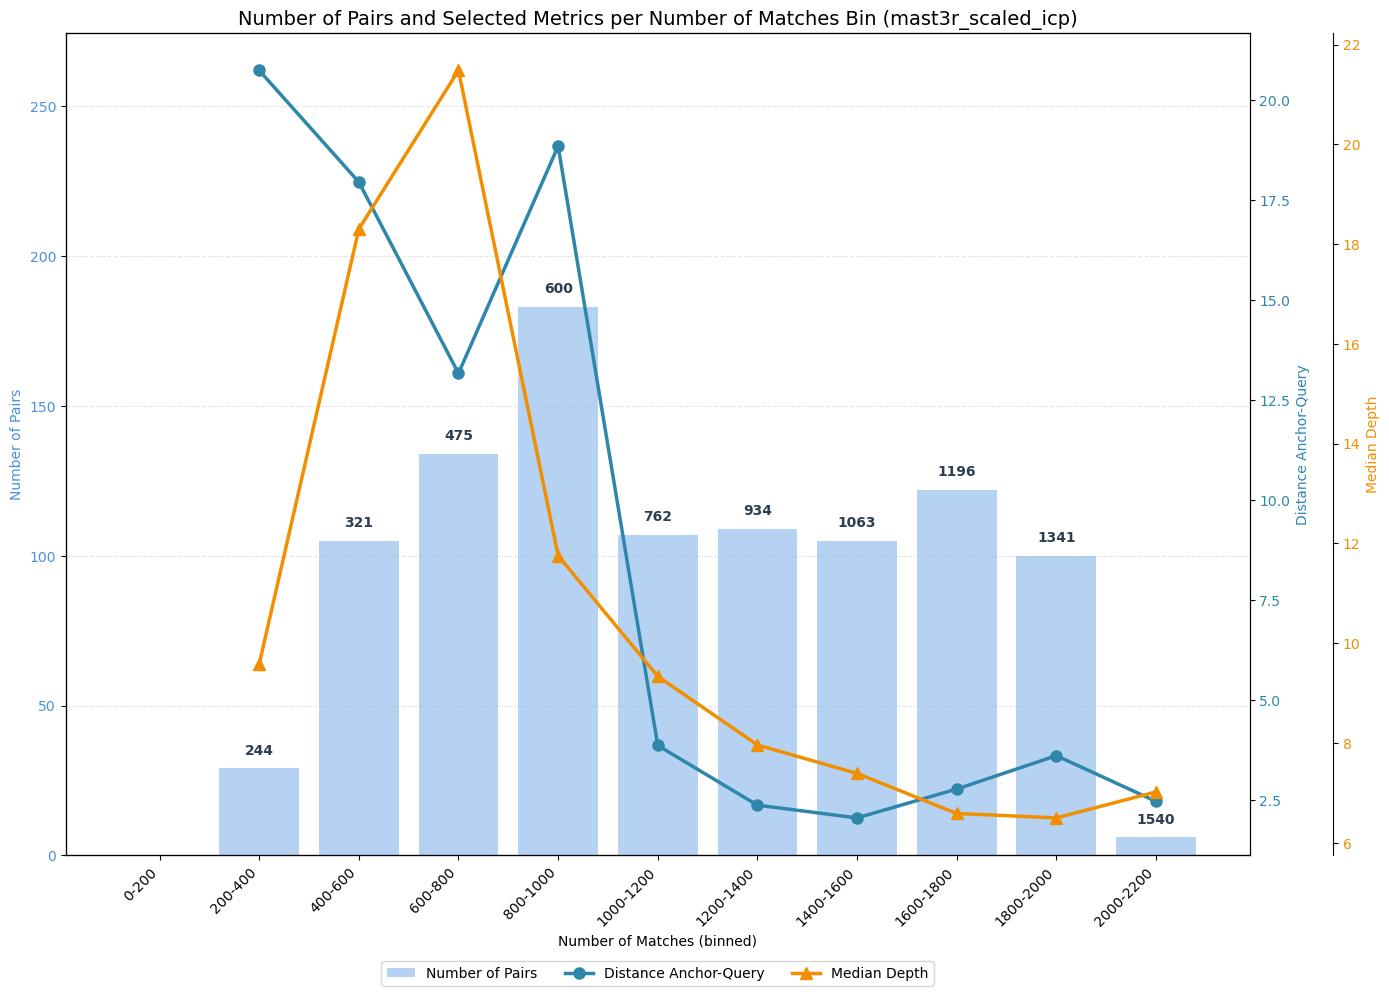


Available metrics in this dataset:
  - num_matches
  - num_inliers
  - median_depth
  - x_error
  - y_error
  - z_error
  - pos_error
  - rot_error
  - distance_anchor_query
  - pointmap_error
  - scale
  - median_depth_bin
  - num_matches_bin


In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Dynamic configuration
dataset_to_plot = 'mast3r_scaled_icp'  # Change this to any method
bin_width = 200  # Adjust bin width as needed

# Choose which metrics to plot with better color palette
metrics_to_plot = {
    'distance_anchor_query': {'color': '#2E86AB', 'marker': 'o', 'label': 'Distance Anchor-Query'},  # Blue
    # 'pos_error': {'color': '#A23B72', 'marker': 's', 'label': 'Position Error'},  # Magenta
    'median_depth': {'color': '#F18F01', 'marker': '^', 'label': 'Median Depth'},  # Orange
    # Add more metrics as needed
    # 'rot_error': {'color': '#C73E1D', 'marker': 'D', 'label': 'Rotation Error'},  # Red
    # 'num_inliers': {'color': '#5D737E', 'marker': 'v', 'label': 'Number of Inliers'},  # Gray-blue
}

# Get the dataset and filter for successful pairs only
df = loaded_data[dataset_to_plot]
df_ok = df[df['status'] == 'OK']  # Only successful pairs for plotting

print(f"Analyzing dataset: {dataset_to_plot}")
print(f"Total pairs: {len(df)}, Successful pairs: {len(df_ok)}")

# Bin the num_matches values
bins = range(0, int(df_ok["num_matches"].max()) + bin_width, bin_width)
df_ok["num_matches_bin"] = pd.cut(df_ok["num_matches"], bins=bins, right=False)

# Group by the bins and compute statistics
grouped = df_ok.groupby("num_matches_bin")
count_by_bin = grouped.size()
median_inliers_by_bin = grouped["num_inliers"].median()

# Compute median for each selected metric
metric_medians = {}
for metric in metrics_to_plot.keys():
    if metric in df_ok.columns:
        metric_medians[metric] = grouped[metric].median()

# Convert bin intervals to numeric values (midpoints)
bin_midpoints = [interval.mid for interval in count_by_bin.index]

# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 10))

# Bar plot: number of pairs per bin (left y-axis) - More transparent
bars = ax1.bar(bin_midpoints, count_by_bin, color="#4A90E2", width=bin_width * 0.8, alpha=0.4, label="Number of Pairs")
ax1.set_ylabel("Number of Pairs", color="#4A90E2")
ax1.tick_params(axis="y", labelcolor="#4A90E2")
ax1.set_xlabel("Number of Matches (binned)")
ax1.set_xticks(bin_midpoints)
ax1.set_xticklabels([f"{int(interval.left)}-{int(interval.right)}" for interval in count_by_bin.index], rotation=45, ha="right")
ax1.set_ylim(0, max(count_by_bin) * 1.5)

# Annotate bars with median inliers
for i, (bar, median_inliers) in enumerate(zip(bars, median_inliers_by_bin)):
    if not pd.isna(median_inliers):  # Only annotate if we have a valid value
        ax1.text(
            bar.get_x() + bar.get_width() / 2,  # Center on bar
            bar.get_height() + max(count_by_bin) * 0.02,  # Slightly above bar
            f"{median_inliers:.0f}",  # Show median inliers as integer
            ha="center", va="bottom", fontsize=10, color="#2C3E50", weight="bold"
        )

# Create additional y-axes for each metric
axes = [ax1]  # Start with the main axis
line_plots = []

for i, (metric, config) in enumerate(metrics_to_plot.items()):
    if metric in metric_medians:
        # Create new y-axis for each metric (except the first one)
        if i == 0:
            ax_metric = ax1.twinx()
        else:
            ax_metric = ax1.twinx()
            # Offset additional axes
            ax_metric.spines["right"].set_position(("outward", 60 * i))
        
        # Plot the metric with better styling
        line = ax_metric.plot(bin_midpoints, metric_medians[metric], 
                            color=config['color'], marker=config['marker'], 
                            label=config['label'], linewidth=2.5, markersize=8)
        ax_metric.set_ylabel(config['label'], color=config['color'])
        ax_metric.tick_params(axis="y", labelcolor=config['color'])
        
        axes.append(ax_metric)
        line_plots.append((line[0], config['label']))

# Combine all legends
legend_items = [(bars, "Number of Pairs")] + line_plots
handles, labels = zip(*legend_items)
ax1.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.12), 
          ncol=min(len(handles), 4), fontsize=10)

# Add grid lines
ax1.grid(axis="y", linestyle="--", alpha=0.3)

# Adjust title and layout
plt.title(f"Number of Pairs and Selected Metrics per Number of Matches Bin ({dataset_to_plot})", fontsize=14)
plt.tight_layout()
plt.show()

# Print available metrics for reference
print("\nAvailable metrics in this dataset:")
available_metrics = [col for col in df_ok.columns if col not in ['query_seq', 'anchor_seq', 'query_idx', 'anchor_idx', 'status']]
for metric in available_metrics:
    print(f"  - {metric}")

Using mast3r_scaled_icp as reference for binning
Binning by: num_inliers
Comparing metric: x_error
Total pairs in reference: 1347, Successful pairs: 1000


/tmp/ipykernel_1499165/3919933737.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ref_ok[bin_column] = pd.cut(df_ref_ok[bin_by], bins=bins, right=False)
/tmp/ipykernel_1499165/3919933737.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_ref = df_ref_ok.groupby(bin_column)
/tmp/ipykernel_1499165/3919933737.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

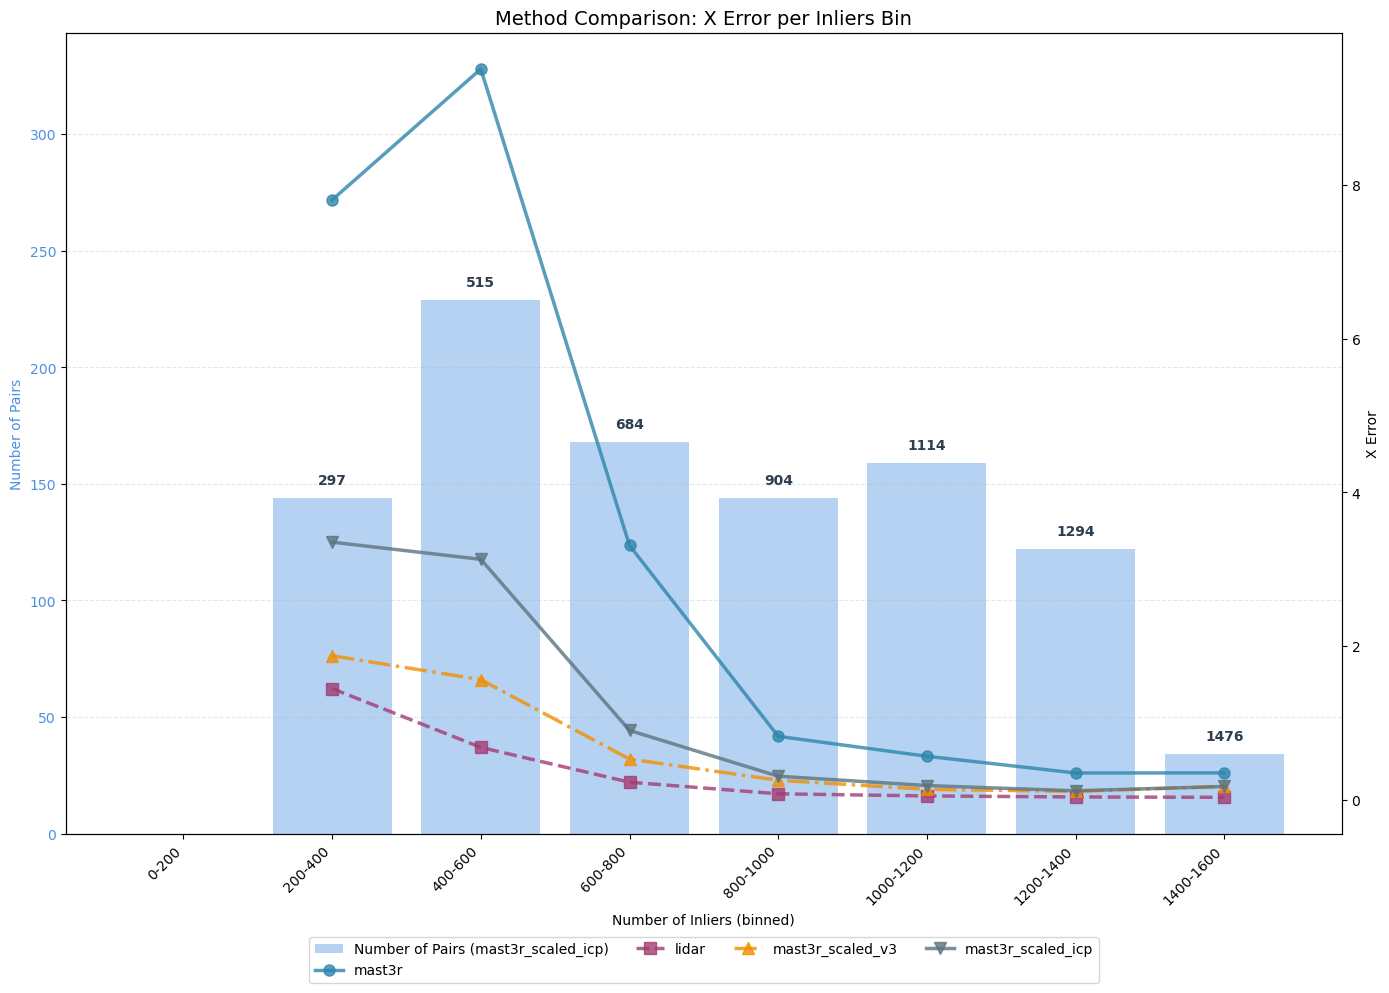


Comparison Statistics for x_error:
mast3r:
  Mean: 3.245
  Median: 0.826
  Min: 0.349
  Max: 9.508
lidar:
  Mean: 0.366
  Median: 0.079
  Min: 0.033
  Max: 1.448
mast3r_scaled_v3:
  Mean: 0.664
  Median: 0.255
  Min: 0.110
  Max: 1.875
mast3r_scaled_icp:
  Mean: 1.167
  Median: 0.307
  Min: 0.117
  Max: 3.353


In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Dynamic configuration
reference_dataset = 'mast3r_scaled_icp'  # Dataset to use for histogram/binning
bin_width = 200  # Adjust bin width as needed
bin_by = 'num_inliers'  # Change this to 'num_matches' or 'num_inliers'

# Choose which metric to compare across methods
metric_to_compare = 'x_error'  # Change this to any metric you want to compare

# Choose which methods to compare (can select multiple)
methods_to_compare = {
    'mast3r': {'color': '#2E86AB', 'marker': 'o', 'linestyle': '-'},
    'lidar': {'color': '#A23B72', 'marker': 's', 'linestyle': '--'},
    'mast3r_scaled_v3': {'color': '#F18F01', 'marker': '^', 'linestyle': '-.'},
    # 'mast3r_scaled_v4': {'color': '#C73E1D', 'marker': 'D', 'linestyle': ':'},
    'mast3r_scaled_icp': {'color': '#5D737E', 'marker': 'v', 'linestyle': '-'},
}

# Get the reference dataset for binning
df_ref = loaded_data[reference_dataset]
df_ref_ok = df_ref[df_ref['status'] == 'OK']

print(f"Using {reference_dataset} as reference for binning")
print(f"Binning by: {bin_by}")
print(f"Comparing metric: {metric_to_compare}")
print(f"Total pairs in reference: {len(df_ref)}, Successful pairs: {len(df_ref_ok)}")

# Validate binning column exists
if bin_by not in df_ref_ok.columns:
    print(f"Error: Column '{bin_by}' not found in reference dataset!")
    print(f"Available columns: {list(df_ref_ok.columns)}")
else:
    # Create bins based on reference dataset and selected binning column
    bins = range(0, int(df_ref_ok[bin_by].max()) + bin_width, bin_width)
    bin_column = f"{bin_by}_bin"
    df_ref_ok[bin_column] = pd.cut(df_ref_ok[bin_by], bins=bins, right=False)

    # Group reference data for histogram
    grouped_ref = df_ref_ok.groupby(bin_column)
    count_by_bin = grouped_ref.size()
    median_inliers_by_bin = grouped_ref["num_inliers"].median()

    # Convert bin intervals to numeric values (midpoints)
    bin_midpoints = [interval.mid for interval in count_by_bin.index]

    # Prepare data for all methods
    method_data = {}
    for method_name in methods_to_compare.keys():
        if method_name in loaded_data:
            df = loaded_data[method_name]
            df_ok = df[df['status'] == 'OK']
            
            # Apply the same binning to this method's data
            df_ok[bin_column] = pd.cut(df_ok[bin_by], bins=bins, right=False)
            grouped = df_ok.groupby(bin_column)
            
            # Compute the metric for this method
            if metric_to_compare in df_ok.columns:
                metric_values = grouped[metric_to_compare].median()
                # Reindex to match the reference bins (fill missing bins with NaN)
                metric_values = metric_values.reindex(count_by_bin.index)
                method_data[method_name] = metric_values
            else:
                print(f"Warning: {metric_to_compare} not found in {method_name}")

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(14, 10))

    # Bar plot: number of pairs per bin from reference dataset (left y-axis)
    bars = ax1.bar(bin_midpoints, count_by_bin, color="#4A90E2", width=bin_width * 0.8, alpha=0.4, 
                   label=f"Number of Pairs ({reference_dataset})")
    ax1.set_ylabel("Number of Pairs", color="#4A90E2")
    ax1.tick_params(axis="y", labelcolor="#4A90E2")
    
    # Dynamic x-axis label based on binning variable
    x_label = "Number of Matches (binned)" if bin_by == 'num_matches' else "Number of Inliers (binned)"
    ax1.set_xlabel(x_label)
    ax1.set_xticks(bin_midpoints)
    ax1.set_xticklabels([f"{int(interval.left)}-{int(interval.right)}" for interval in count_by_bin.index], 
                        rotation=45, ha="right")
    ax1.set_ylim(0, max(count_by_bin) * 1.5)

    # Annotate bars with median inliers from reference dataset
    for i, (bar, median_inliers) in enumerate(zip(bars, median_inliers_by_bin)):
        if not pd.isna(median_inliers):
            ax1.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + max(count_by_bin) * 0.02,
                f"{median_inliers:.0f}",
                ha="center", va="bottom", fontsize=10, color="#2C3E50", weight="bold"
            )

    # Create secondary y-axis for the metric comparison
    ax2 = ax1.twinx()
    ax2.set_ylabel(f"{metric_to_compare.replace('_', ' ').title()}", color="black")

    # Plot the metric for each method
    line_plots = []
    for method_name, config in methods_to_compare.items():
        if method_name in method_data:
            line = ax2.plot(bin_midpoints, method_data[method_name], 
                           color=config['color'], marker=config['marker'], 
                           linestyle=config['linestyle'], label=method_name,
                           linewidth=2.5, markersize=8, alpha=0.8)
            line_plots.append((line[0], method_name))

    # Combine legends
    legend_items = [(bars, f"Number of Pairs ({reference_dataset})")] + line_plots
    handles, labels = zip(*legend_items)
    ax1.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.12), 
              ncol=min(len(handles), 4), fontsize=10)

    # Add grid lines
    ax1.grid(axis="y", linestyle="--", alpha=0.3)

    # Dynamic title based on binning variable
    bin_label = "Matches" if bin_by == 'num_matches' else "Inliers"
    plt.title(f"Method Comparison: {metric_to_compare.replace('_', ' ').title()} per {bin_label} Bin", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Print comparison statistics
    print(f"\nComparison Statistics for {metric_to_compare}:")
    print("=" * 50)
    for method_name in methods_to_compare.keys():
        if method_name in method_data:
            values = method_data[method_name].dropna()
            if len(values) > 0:
                print(f"{method_name}:")
                print(f"  Mean: {values.mean():.3f}")
                print(f"  Median: {values.median():.3f}")
                print(f"  Min: {values.min():.3f}")
                print(f"  Max: {values.max():.3f}")
            else:
                print(f"{method_name}: No data available")
        else:
            print(f"{method_name}: Not loaded")